In [41]:
%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib as mpl

import numpy as np
import pandas as pd

from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.layers.noise import GaussianNoise
from keras.utils import np_utils
from keras.constraints import maxnorm

from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import backend as K
K.set_image_data_format('channels_first')

import seaborn as sns
sns.set(font_scale=2, style="ticks")

In [2]:
HSC_ids = np.load("data/HSC_ids.npy")
HSC_ids

array([43158176442374224, 43158176442374373, 43158176442374445, ...,
       43159155694916013, 43159155694916476, 43159155694917496])

In [3]:
X = np.load("data/images.small.npy")
X.shape

(1866, 3, 50, 50)

# Get targets

In [4]:
df = pd.read_csv("data/2018_02_23-all_objects.csv")
df = df[df.selected]
df.head()



targets = df.drop_duplicates("HSC_id") \
            .set_index("HSC_id") \
    


targets = (targets.log_mass > 8) & (targets.log_mass < 9) & (targets.photo_z < .15)
print(targets.mean())
print(targets.sum())

0.2775
555


# Split training and validation sets

In [5]:
batch_size = 64

In [6]:
np.random.seed(seed=0)

randomized_indices = np.arange(X.shape[0])
np.random.shuffle(randomized_indices)

testing_fraction = 0.2
# make sure testing set size is an even multiple of 64
num_testing = (int(testing_fraction*X.shape[0]) // batch_size) * batch_size

testing_set_indices = randomized_indices[:int(num_testing)]
training_set_indices = np.array(list(set([*randomized_indices]) - set([*testing_set_indices])))

In [7]:
testing_set_indices.size


320

In [8]:
training_set_indices.size


1546

# Setup standard augmentation

In [9]:
# from keras.preprocessing.image import NumpyArrayIterator

In [10]:
from keras.preprocessing.image import ImageDataGenerator

In [11]:
print('Using real-time _simple_ data augmentation.')

h_before, w_before = X[0,0].shape
print("image shape before: ({},{})".format(h_before, w_before))

# this will do preprocessing and realtime data augmentation
datagen = ImageDataGenerator(
    featurewise_center=False,  # set input mean to 0 over the dataset
    samplewise_center=False,  # set each sample mean to 0
    featurewise_std_normalization=False,  # divide inputs by std of the dataset
    samplewise_std_normalization=False,  # divide each input by its std
    zca_whitening=False,  # apply ZCA whitening
    horizontal_flip=True, # randomly apply a reflection (in x)
    vertical_flip=True, # randomly apply a reflection (in y)
    rotation_range=0, # randomly apply a rotation of angle randomly between 0 and `rotation_range`
    zoom_range=0.0,
    shear_range=0.0,
    channel_shift_range=0.0,
    rescale=0,
    width_shift_range=0.002,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.002,  # randomly shift images vertically (fraction of total height)
)

Using real-time _simple_ data augmentation.
image shape before: (50,50)


In [12]:
datagen.fit(X[training_set_indices])

# Setup `keras` model

In [13]:
n_conv_filters = 16
conv_kernel_size = 4
input_shape = X.shape[1:]

dropout_fraction = .25

nb_dense = 64

In [14]:
input_shape

(3, 50, 50)

In [15]:
model = Sequential()

model.add(Conv2D(n_conv_filters, conv_kernel_size,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))


model.add(Conv2D(n_conv_filters, conv_kernel_size*2,
                        padding='same',))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Conv2D(n_conv_filters, conv_kernel_size*4,
                        padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(dropout_fraction))

model.add(Flatten())
model.add(Dense(2*nb_dense, activation="relu"))
model.add(Dense(nb_dense, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [16]:
learning_rate = 0.001
decay = 1e-5
momentum = 0.9

sgd = SGD(lr=learning_rate, decay=decay, momentum=momentum, nesterov=True)

adam = Adam(lr=learning_rate)

In [17]:
model.compile(loss='binary_crossentropy', 
#               optimizer=sgd, 
              optimizer=adam,
#               metrics=["accuracy"]
             )

In [18]:
earlystopping = EarlyStopping(monitor='loss',
                              patience=35,
                              verbose=1,
                              mode='auto' )


# Run Basic Keras Model

In [19]:
goal_batch_size = 64
steps_per_epoch = max(2, training_set_indices.size//goal_batch_size)
batch_size = training_set_indices.size//steps_per_epoch
print("steps_per_epoch: ", steps_per_epoch)
print("batch_size: ", batch_size)
epochs = 100
verbose=1

steps_per_epoch:  24
batch_size:  64


In [20]:
Y = targets[HSC_ids].values

In [21]:
# %%timeit -r 1 -n 1
history = model.fit_generator(datagen.flow(X[training_set_indices], Y[training_set_indices],
                                           batch_size=batch_size,
                                          ),
                              steps_per_epoch=steps_per_epoch,
                              epochs=epochs,
                              validation_data=(X[testing_set_indices], Y[testing_set_indices]),
                              verbose=verbose,
                              callbacks=[earlystopping],
                              )  

Epoch 1/100
24/24 [==============================] - 11s 474ms/step - loss: 0.6041 - val_loss: 0.6064
Epoch 2/100
24/24 [==============================] - 11s 468ms/step - loss: 0.5915 - val_loss: 0.6052
Epoch 3/100
24/24 [==============================] - 11s 456ms/step - loss: 0.5816 - val_loss: 0.6069
Epoch 4/100
24/24 [==============================] - 11s 474ms/step - loss: 0.5779 - val_loss: 0.6045
Epoch 5/100
24/24 [==============================] - 11s 464ms/step - loss: 0.5763 - val_loss: 0.6077
Epoch 6/100
24/24 [==============================] - 11s 457ms/step - loss: 0.5755 - val_loss: 0.5956
Epoch 7/100
24/24 [==============================] - 11s 459ms/step - loss: 0.5745 - val_loss: 0.5931
Epoch 8/100
24/24 [==============================] - 11s 457ms/step - loss: 0.5660 - val_loss: 0.6036
Epoch 9/100
24/24 [==============================] - 11s 455ms/step - loss: 0.5843 - val_loss: 0.6080
Epoch 10/100
24/24 [==============================] - 11s 464ms/step - loss: 0.562

In [22]:
print("best performance: ", min(history.history["val_loss"]))

best performance:  0.558653271198


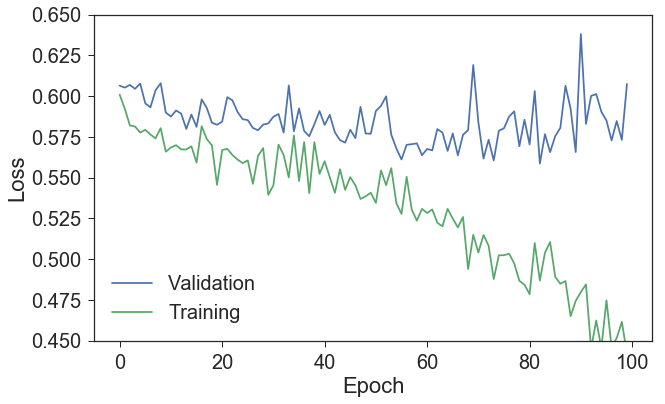

In [43]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):

    plt.plot(history.history["val_loss"], label="Validation")
    plt.plot(history.history["loss"], label="Training")


    plt.legend()
    
    plt.xlabel("Epoch")
#     plt.ylabel("Loss\n(avg. binary cross-entropy)")
    plt.ylabel("Loss")

    
    plt.ylim(.45, .65)

In [31]:
class_probs = model.predict_proba(X[testing_set_indices]).flatten()
class_probs

320/320 [==============================] - 1s 2ms/step


array([ 0.19405042,  0.6779356 ,  0.0986942 ,  0.34136057,  0.36466083,
        0.53943187,  0.29394048,  0.01790394,  0.364007  ,  0.3702932 ,
        0.66467285,  0.43467727,  0.42269495,  0.14806426,  0.42212713,
        0.19365868,  0.50902522,  0.37859157,  0.360843  ,  0.27123341,
        0.06114086,  0.09459081,  0.41454765,  0.19553185,  0.13642959,
        0.34020227,  0.05184221,  0.38702831,  0.01000692,  0.53954202,
        0.42403251,  0.35969615,  0.22209302,  0.34178606,  0.34316298,
        0.00849582,  0.65595579,  0.39215514,  0.37688828,  0.25865746,
        0.42702052,  0.41963321,  0.23161516,  0.33996898,  0.34804729,
        0.58642054,  0.56518048,  0.68953836,  0.69504434,  0.44555488,
        0.01099534,  0.24169311,  0.09993142,  0.30656174,  0.29104292,
        0.06375348,  0.11109658,  0.22774023,  0.32821378,  0.30538908,
        0.40003106,  0.28391752,  0.2608394 ,  0.07656628,  0.17589951,
        0.05072496,  0.39500898,  0.04272058,  0.6300292 ,  0.17

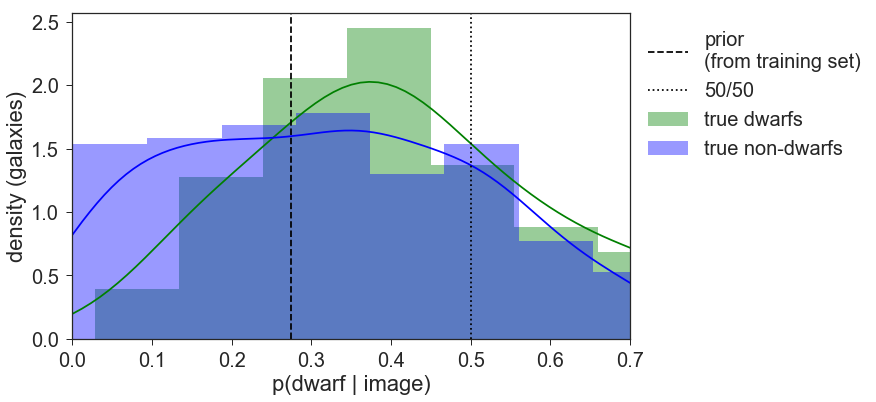

In [44]:
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    sns.distplot(class_probs[Y[testing_set_indices]==True], color="g", label="true dwarfs")
    sns.distplot(class_probs[Y[testing_set_indices]==False], color="b", label="true non-dwarfs")

    plt.xlabel("p(dwarf | image)")
    plt.ylabel("density (galaxies)")

    plt.xlim(0, .7)
    plt.axvline(Y[training_set_indices].mean(), linestyle="dashed", color="black", label="prior\n(from training set)")
    plt.axvline(.5, linestyle="dotted", color="black", label="50/50")

    plt.legend(
        loc="upper left",
        bbox_to_anchor=(1, 1),
    )


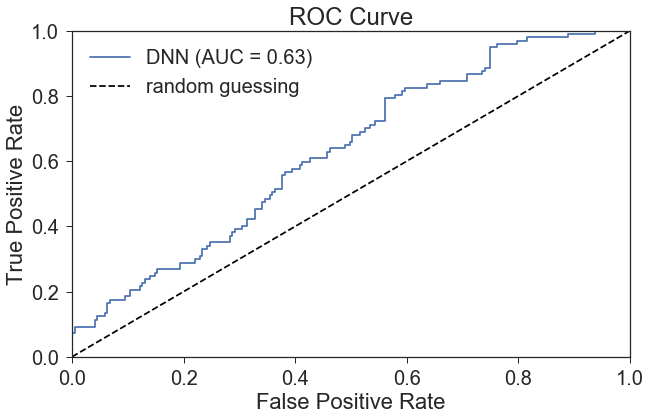

In [45]:
from sklearn import metrics
from sklearn.metrics import roc_auc_score

with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    fpr, tpr, _ = metrics.roc_curve(Y[testing_set_indices], class_probs)
    roc_auc = roc_auc_score(Y[testing_set_indices], class_probs)

    plt.plot(fpr, tpr, label="DNN (AUC = {:.2})".format(roc_auc))
    plt.plot([0,1], [0,1], linestyle="dashed", color="black", label="random guessing")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

    plt.title("ROC Curve")

    plt.legend(loc="best")


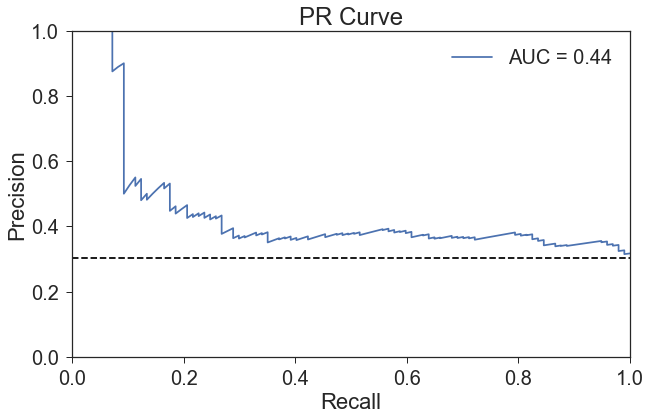

In [46]:
from sklearn import metrics
from sklearn.metrics import average_precision_score
with mpl.rc_context(rc={"figure.figsize": (10,6)}):
    precision, recall, _ = metrics.precision_recall_curve(Y[testing_set_indices], class_probs)
    pr_auc = average_precision_score(Y[testing_set_indices], class_probs)

    plt.plot(recall, precision, label="AUC = {:.2}".format(pr_auc))
    plt.plot([0,1], [Y[testing_set_indices].mean()]*2, linestyle="dashed", color="black")

    plt.xlim(0,1)
    plt.ylim(0,1)

    plt.xlabel("Recall")
    plt.ylabel("Precision")

    plt.title("PR Curve")

    plt.legend(loc="best")
